# UV RADIATION EXPOSURE AND MELANOMA INCIDENCE 

Combining environmental UV exposure data with cancer incidence statistics to examine melanoma risk across U.S. counties.

In [2120]:
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

### Importing datasets

- `uv_county` includes historical Average Daily Global Solar Radiation estimates (AVGLO) - a proxy measure for UV - in Wh/m² by county in the Continental US for the period 1961-1990 and the more recent 5-year average measures (2020 - 2024);

- `melanoma_county`  melanoma reported cases per county in 2023.

### Investigate sheet names as shown <a href="https://stackoverflow.com/questions/17977540/pandas-looking-up-the-list-of-sheets-in-an-excel-file" target="_blank">here</a>

In [2121]:
uv_exposure = pd.ExcelFile('../datasets/uv-county-exposure.xlsx')
uv_exposure.sheet_names


['UV_County_1961-1990', 'UV_County_2000-2024']

In [2122]:
recent_uv = pd.read_excel('../datasets/uv-county-exposure.xlsx', sheet_name='UV_County_2000-2024', dtype={'COUNTY_FIPS': str})
recent_uv.rename({'COUNTY NAME': 'COUNTY_NAME', 'STATENAME': 'STATE_NAME'}, axis=1, inplace=True)
recent_uv['COUNTY_FIPS'] = recent_uv['COUNTY_FIPS'].str.zfill(5)
recent_uv = recent_uv.sort_values(['STATE_NAME', 'COUNTY_NAME'])
recent_uv


,STATE_NAME,COUNTY_NAME,COUNTY_FIPS,UV_ Wh/m² (2000-2004),UV_ Wh/m² (2005-2009),UV_ Wh/m² (2010-2014),UV_ Wh/m² (2015-2019),UV_ Wh/m² (2020_2024)
2734,Alabama,Autauga,01001,4781.877818,4774.090182,4843.185939,4701.004606,4785.906061
2159,Alabama,Baldwin,01003,4916.409224,4904.892424,4934.852894,4764.348800,4814.548819
565,Alabama,Barbour,01005,4875.885667,4862.169667,4908.160333,4786.408667,4833.696667
974,Alabama,Bibb,01007,4727.518560,4706.299680,4785.613440,4625.073600,4726.646400
2232,Alabama,Blount,01009,4643.034462,4606.273385,4687.476000,4574.497846,4665.236538
...,...,...,...,...,...,...,...,...
1527,Wyoming,Sweetwater,56037,4780.547753,4819.313629,4731.694674,4753.577473,4910.167898
1517,Wyoming,Teton,56039,4294.326031,4282.941613,4162.277026,4303.009508,4529.784895
2234,Wyoming,Uinta,56041,4730.583808,4797.226752,4687.229184,4736.682624,4936.341280
1990,Wyoming,Washakie,56043,4558.186982,4545.855054,4427.304308,4473.671815,4565.537275


In [2123]:
recent_uv.isna().sum() * 100/len(recent_uv)

# recent_uv['COUNTY_FIPS'].unique()

STATE_NAME               0.0
COUNTY_NAME              0.0
COUNTY_FIPS              0.0
UV_ Wh/m² (2000-2004)    0.0
UV_ Wh/m² (2005-2009)    0.0
UV_ Wh/m² (2010-2014)    0.0
UV_ Wh/m² (2015-2019)    0.0
UV_ Wh/m² (2020_2024)    0.0
dtype: float64

In [2124]:
melanoma_incidence = pd.read_csv('../datasets/melanoma-county-incidence.csv', dtype={'FIPS': str}, skiprows=8, skipfooter=35, engine='python')
melanoma_incidence.columns
melanoma_incidence.drop(columns=['County', 
                                 '2023 Rural-Urban Continuum Codes([rural urban note])', 
                                 'Lower 95% Confidence Interval', 
                                 'Upper 95% Confidence Interval', 
                                 'CI*Rank([rank note])', 
                                 'Lower CI (CI*Rank)', 
                                 'Upper CI (CI*Rank)', 
                                 'Recent 5-Year Trend ([trend note]) in Incidence Rates', 
                                 'Lower 95% Confidence Interval.1', 
                                 'Upper 95% Confidence Interval.1'], inplace=True)
melanoma_incidence.rename({'FIPS': 'COUNTY_FIPS', 
                           'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000': 'AGE_RATE_PER100K', 
                           'Average Annual Count': 'AVG_ANNUAL_COUNT', 
                           'Recent Trend': 'RECENT_TREND'}, axis=1, inplace=True)
melanoma_incidence['COUNTY_FIPS'] = melanoma_incidence['COUNTY_FIPS'].str.zfill(5)
melanoma_incidence = melanoma_incidence[melanoma_incidence['COUNTY_FIPS'] != '00000'] # drops the annual agreggate row that has COUNTY_FIPS = '00000'
melanoma_incidence = melanoma_incidence.sort_values(['COUNTY_FIPS'])
melanoma_incidence

,COUNTY_FIPS,AGE_RATE_PER100K,AVG_ANNUAL_COUNT,RECENT_TREND
1096,01001,24,16,stable
217,01003,37.2,115,stable
1209,01005,22.8,8,*
1909,01007,15.5,4,*
1569,01009,19.4,14,falling
...,...,...,...,...
292,56039,35.2,10,stable
1836,56041,16.4,4,falling
3090,56043,*,3 or fewer,*
3108,56045,*,3 or fewer,*


In [2125]:
melanoma_incidence.isna().sum() * 100/len(melanoma_incidence)

COUNTY_FIPS         0.0
AGE_RATE_PER100K    0.0
AVG_ANNUAL_COUNT    0.0
RECENT_TREND        0.0
dtype: float64

In [2126]:
# Merge DFs

merged_df = recent_uv.merge(melanoma_incidence, how='left', on ='COUNTY_FIPS')
merged_df

,STATE_NAME,COUNTY_NAME,COUNTY_FIPS,UV_ Wh/m² (2000-2004),UV_ Wh/m² (2005-2009),UV_ Wh/m² (2010-2014),UV_ Wh/m² (2015-2019),UV_ Wh/m² (2020_2024),AGE_RATE_PER100K,AVG_ANNUAL_COUNT,RECENT_TREND
0,Alabama,Autauga,01001,4781.877818,4774.090182,4843.185939,4701.004606,4785.906061,24,16,stable
1,Alabama,Baldwin,01003,4916.409224,4904.892424,4934.852894,4764.348800,4814.548819,37.2,115,stable
2,Alabama,Barbour,01005,4875.885667,4862.169667,4908.160333,4786.408667,4833.696667,22.8,8,*
3,Alabama,Bibb,01007,4727.518560,4706.299680,4785.613440,4625.073600,4726.646400,15.5,4,*
4,Alabama,Blount,01009,4643.034462,4606.273385,4687.476000,4574.497846,4665.236538,19.4,14,falling
...,...,...,...,...,...,...,...,...,...,...,...
3102,Wyoming,Sweetwater,56037,4780.547753,4819.313629,4731.694674,4753.577473,4910.167898,24.8,11,stable
3103,Wyoming,Teton,56039,4294.326031,4282.941613,4162.277026,4303.009508,4529.784895,35.2,10,stable
3104,Wyoming,Uinta,56041,4730.583808,4797.226752,4687.229184,4736.682624,4936.341280,16.4,4,falling
3105,Wyoming,Washakie,56043,4558.186982,4545.855054,4427.304308,4473.671815,4565.537275,*,3 or fewer,*


In [2127]:

# Trim whitespaces and normalize strings
merged_df.columns = merged_df.columns.str.strip()

cols = ['STATE_NAME', 'COUNTY_NAME', 'COUNTY_FIPS', 'AGE_RATE_PER100K', 'AVG_ANNUAL_COUNT', 'RECENT_TREND']

merged_df[cols] = merged_df[cols].apply(lambda x: x.str.strip().str.capitalize())


In [2128]:
# Check datatypes (columns AGE_RATE_PER100K and AVG_ANNUAL_COUNT must be of type float64)
merged_df.dtypes

STATE_NAME                object
COUNTY_NAME               object
COUNTY_FIPS               object
UV_ Wh/m² (2000-2004)    float64
UV_ Wh/m² (2005-2009)    float64
UV_ Wh/m² (2010-2014)    float64
UV_ Wh/m² (2015-2019)    float64
UV_ Wh/m² (2020_2024)    float64
AGE_RATE_PER100K          object
AVG_ANNUAL_COUNT          object
RECENT_TREND              object
dtype: object

In [2129]:
# Checking Unique Count of Unique values: 'data not available' , '*" and 'nan' values will become NaN for calculations
merged_df['AGE_RATE_PER100K'].unique()

array(['24', '37.2', '22.8', '15.5', '19.4', '*', '17.9', '25.2', '9.1',
       '17.5', '17.7', '19.8', '21.7', '18.7', '22.5', '21.4', '20.3',
       '20.5', '26.2', '25.8', '11.8', '27.6', '18.8', '21.1', '16.9',
       '15.1', '39.7', '38.7', '29.2', '15.9', '24.5', '20.6', '32.8',
       '31.7', '25.5', '20.2', '22.4', '20.7', '13.6', '14.9', '28.9',
       '9.4', '16.1', '25', '14.2', '25.4', '17', '12.2', '30', '23.8',
       '18.5', '22', '33.5', '21.6', '16.2', '34.1', '31.2', '15.3',
       '35.3', '9.5', '26.8', '25.7', '30.7', '16', '26.7', '28.3', '7',
       '25.9', '24.9', '27.8', '26.5', '37.1', '18.9', '18.4', '22.3',
       '16.8', '23.2', '23.1', '24.2', '17.8', '24.7', '29.6', '14.8',
       '13.1', '13.4', '14.5', '28.7', '13', '23.4', '24.4', '22.1',
       '30.9', '33.1', '21.8', '12', '19.5', '31.5', '36.2', '25.3',
       '30.1', '36.8', '31.3', '33.6', '5.8', '18.6', '11.1', '20',
       '12.7', '57.1', '28.1', '29.9', '33.2', '26.6', '38.9', '40.4',
       '24

In [2130]:
# '3 or fewer' values were turned into a safe 1.5 value - nan and 'data not available will also become NaN for calculations
merged_df['AVG_ANNUAL_COUNT'] = (merged_df['AVG_ANNUAL_COUNT'].replace('3 or fewer', 1.5))
merged_df['AVG_ANNUAL_COUNT'].unique()

array(['16', '115', '8', '4', '14', 1.5, '5', '33', '6', '10', '7', '3',
       '29', '15', '17', '28', '9', '27', '13', '39', '20', '120', '25',
       '26', '37', '112', '101', '38', '44', '53', '23', '21', '56', '34',
       '19', '1665', '81', '22', '485', '179', '161', '77', '11', '24',
       '111', '47', '36', '50', '366', '97', '420', '106', '178', '152',
       '1397', '40', '221', '122', '59', '66', '1102', '216', '667',
       '393', '355', '1104', '212', '140', '210', '254', '135', '151',
       '83', '283', '119', '58', '276', '49', '76', '142', '104', '12',
       '136', '129', '171', '60', '65', '63', '228', '207', '52', '192',
       '42', '54', '158', '130', '68', '72', '310', '483', '96', '88',
       '256', '286', '117', '73', '423', '141', '143', '476', '257',
       '163', '64', '234', '604', '260', '479', '306', '71', '335', '145',
       '102', '35', '100', '18', '205', '131', '123', '303', '30', '103',
       '48', '32', '193', '61', '31', '920', '270', '84', '1

In [2131]:
merged_df['RECENT_TREND'].unique()

array(['Stable', '*', 'Falling', 'Rising', 'Data not available', nan],
      dtype=object)

In [2132]:
# Standardized non available data for 'unkown'
merged_df['RECENT_TREND'] = (merged_df['RECENT_TREND'].replace(['data not available', '*'], 'Unkown')).fillna('Unkown')

merged_df['RECENT_TREND'].value_counts().sum()


np.int64(3107)

In [2133]:
merged_df['RECENT_TREND'].unique()

array(['Stable', 'Unkown', 'Falling', 'Rising', 'Data not available'],
      dtype=object)

### Issue observed when normalizing data types:

There were a coupe of rows that had no data available for columns `AGE_RATE_PER100K` and `AVG_ANNUAL_COUNT`.<br>
I did not want to `.drop()` these rows, because I thought values would be skewed.<br>
Instead, used this guidance found <a href="https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns" target="_blank">here</a> to apply `pd.to_numeric()` and then convert selected columns to numeric dtypes.

In [2134]:
str_to_nan = ["AGE_RATE_PER100K", "AVG_ANNUAL_COUNT"]
merged_df[str_to_nan] = merged_df[str_to_nan].apply(pd.to_numeric, errors="coerce")

merged_df



,STATE_NAME,COUNTY_NAME,COUNTY_FIPS,UV_ Wh/m² (2000-2004),UV_ Wh/m² (2005-2009),UV_ Wh/m² (2010-2014),UV_ Wh/m² (2015-2019),UV_ Wh/m² (2020_2024),AGE_RATE_PER100K,AVG_ANNUAL_COUNT,RECENT_TREND
0,Alabama,Autauga,01001,4781.877818,4774.090182,4843.185939,4701.004606,4785.906061,24.0,16.0,Stable
1,Alabama,Baldwin,01003,4916.409224,4904.892424,4934.852894,4764.348800,4814.548819,37.2,115.0,Stable
2,Alabama,Barbour,01005,4875.885667,4862.169667,4908.160333,4786.408667,4833.696667,22.8,8.0,Unkown
3,Alabama,Bibb,01007,4727.518560,4706.299680,4785.613440,4625.073600,4726.646400,15.5,4.0,Unkown
4,Alabama,Blount,01009,4643.034462,4606.273385,4687.476000,4574.497846,4665.236538,19.4,14.0,Falling
...,...,...,...,...,...,...,...,...,...,...,...
3102,Wyoming,Sweetwater,56037,4780.547753,4819.313629,4731.694674,4753.577473,4910.167898,24.8,11.0,Stable
3103,Wyoming,Teton,56039,4294.326031,4282.941613,4162.277026,4303.009508,4529.784895,35.2,10.0,Stable
3104,Wyoming,Uinta,56041,4730.583808,4797.226752,4687.229184,4736.682624,4936.341280,16.4,4.0,Falling
3105,Wyoming,Washakie,56043,4558.186982,4545.855054,4427.304308,4473.671815,4565.537275,NaN,1.5,Unkown


In [2135]:
# All dtypes normalized
merged_df.dtypes

STATE_NAME                object
COUNTY_NAME               object
COUNTY_FIPS               object
UV_ Wh/m² (2000-2004)    float64
UV_ Wh/m² (2005-2009)    float64
UV_ Wh/m² (2010-2014)    float64
UV_ Wh/m² (2015-2019)    float64
UV_ Wh/m² (2020_2024)    float64
AGE_RATE_PER100K         float64
AVG_ANNUAL_COUNT         float64
RECENT_TREND              object
dtype: object

In [2136]:
merged_df = merged_df.drop_duplicates()
merged_df.sort_values('AVG_ANNUAL_COUNT')

,STATE_NAME,COUNTY_NAME,COUNTY_FIPS,UV_ Wh/m² (2000-2004),UV_ Wh/m² (2005-2009),UV_ Wh/m² (2010-2014),UV_ Wh/m² (2015-2019),UV_ Wh/m² (2020_2024),AGE_RATE_PER100K,AVG_ANNUAL_COUNT,RECENT_TREND
1393,Mississippi,Humphreys,28053,4809.966806,4781.584478,4888.708299,4667.541493,4772.261194,NaN,1.5,Unkown
1783,New mexico,Roosevelt,35041,5640.492000,5557.717837,5698.932612,5547.314204,5591.581684,NaN,1.5,Unkown
1785,New mexico,San miguel,35047,5509.724105,5437.762304,5554.942618,5417.258262,5471.762435,NaN,1.5,Unkown
1814,New york,Hamilton,36041,3797.156613,3701.880883,3730.671313,3792.000147,3641.048466,NaN,1.5,Unkown
45,Alabama,Marengo,01091,4802.078137,4831.190466,4869.972164,4698.425096,4794.147534,NaN,1.5,Unkown
...,...,...,...,...,...,...,...,...,...,...,...
955,Kansas,Wichita,20203,5063.373620,4916.895471,5080.266050,4940.710215,5043.678843,NaN,NaN,Data not available
956,Kansas,Wilson,20205,4649.040485,4463.695515,4622.450909,4498.244848,4620.583030,NaN,NaN,Data not available
957,Kansas,Woodson,20207,4651.207481,4447.435636,4615.613922,4491.869922,4610.330649,NaN,NaN,Data not available
958,Kansas,Wyandotte,20209,4508.204690,4284.099310,4430.850207,4337.366069,4449.873103,NaN,NaN,Data not available


# EDA

In [2137]:
merged_df.isna().sum()


STATE_NAME                 0
COUNTY_NAME                0
COUNTY_FIPS                0
UV_ Wh/m² (2000-2004)      0
UV_ Wh/m² (2005-2009)      0
UV_ Wh/m² (2010-2014)      0
UV_ Wh/m² (2015-2019)      0
UV_ Wh/m² (2020_2024)      0
AGE_RATE_PER100K         935
AVG_ANNUAL_COUNT         198
RECENT_TREND               0
dtype: int64

In [2138]:
# This aggregation groups by state name and gets the average UV exposure over a 25 year span.
avg_uv_states_25yr = merged_df.groupby('STATE_NAME')[
    ['UV_ Wh/m² (2000-2004)', 
     'UV_ Wh/m² (2005-2009)', 
     'UV_ Wh/m² (2010-2014)', 
     'UV_ Wh/m² (2015-2019)', 
     'UV_ Wh/m² (2020_2024)'
    ]
].mean().mean(axis=1).sort_values(ascending=False).head(10)

avg_uv_states_25yr

STATE_NAME
Arizona       5734.544264
New mexico    5585.910753
California    5274.362519
Nevada        5255.790811
Texas         5140.739160
Florida       5035.838943
Utah          5003.156992
Colorado      5002.777573
Oklahoma      4824.321708
Louisiana     4818.284650
dtype: float64

### What are the top 10 U.S. states with the highest average UV exposure between 2000 and 2024?

The bar chart below addresses this question by comparing the average UV exposure across states over a 25-year span.<br>
The choice for this chart was justified by the need to display differences between categorical values (U.S States), and a quantitative measure (UV exposure, measured in Wh/m²).

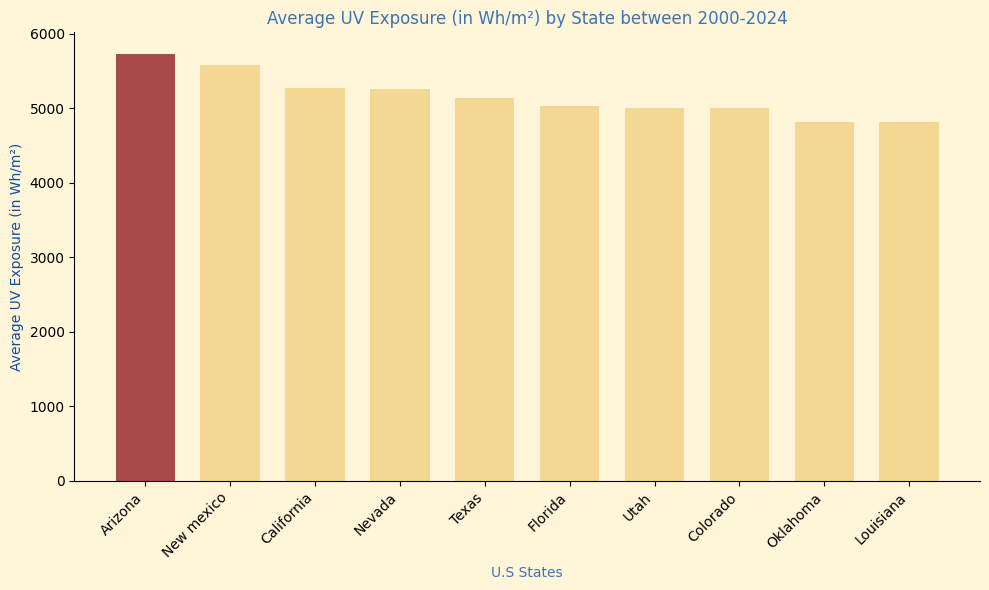

In [ ]:


plt.figure(figsize=(10, 6), facecolor="#FFF6DA")
colors = ["#F4D793"]*len(avg_uv_states_25yr)

max_index = avg_uv_states_25yr.idxmax()
highlight_position = avg_uv_states_25yr.index.get_loc(max_index)
colors[highlight_position] = "#A94A4A"

plt.bar(avg_uv_states_25yr.index, avg_uv_states_25yr.values, color = colors, width=0.7)


ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("#FFF6DA") # Change background color behind axes

plt.xlabel("U.S States", color='#0E4E9C')
plt.ylabel("Average UV Exposure (in Wh/m²)", color="#0E4E9C")
plt.title("Average UV Exposure (in Wh/m²) by State between 2000-2024", color='#0E4E9C')
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

### Do the top five states with higher UV Exposure have also the highest reports of melanoma?

The Histogram below shows the distribution rates of reported melanoma across the five states with the highest UV exposure.<br>
The chart helps us notice that, contrary to what one would have thought, the melanoma incidence in these states is not uniformly high.<br>
Instead, most counties show moderate incidence rates, with fewer counties exhibiting substantially higher values.

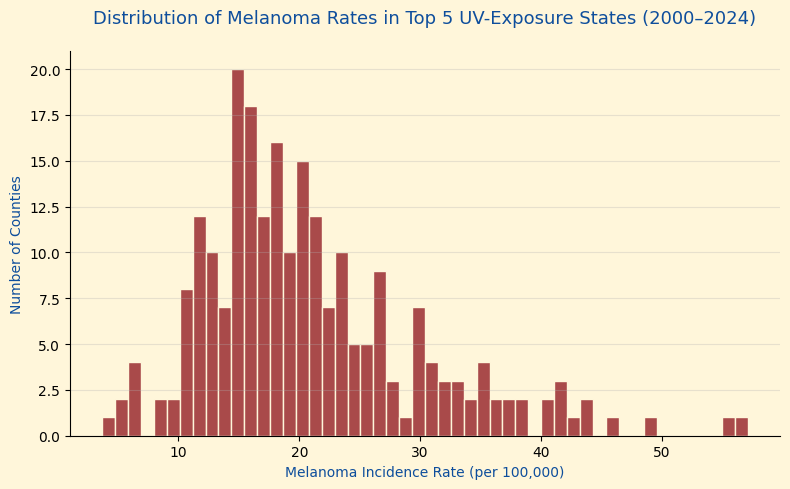

In [2168]:
top5_df = merged_df[merged_df['STATE_NAME'].isin(avg_uv_states_25yr.sort_values(ascending=False).head(5).index)]

plt.figure(figsize=(8, 5), facecolor="#FFF6DA")

plt.hist(
    top5_df['AGE_RATE_PER100K'].dropna(),
    bins=50,
    color="#A94A4A",
    edgecolor = "#FFF6DA"
)

ax = plt.gca()
ax.set_facecolor("#FFF6DA")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis='y', alpha=0.3)

plt.xlabel("Melanoma Incidence Rate (per 100,000)", color="#0E4E9C", fontsize=10)
plt.ylabel("Number of Counties", color="#0E4E9C", fontsize=10)
plt.title("Distribution of Melanoma Rates in Top 5 UV-Exposure States (2000–2024)", color="#0E4E9C", fontsize=13, pad=20)

plt.tight_layout()
plt.show()

### Is there a relationship between UV exposure and melanoma incidence at state level?

This scatterplot compares average UV exposure and melanoma incidence across Arizona's counties.<br>
The distribution of points suggests that high UV exposure alone does not explain high variation in melanoma incidence.

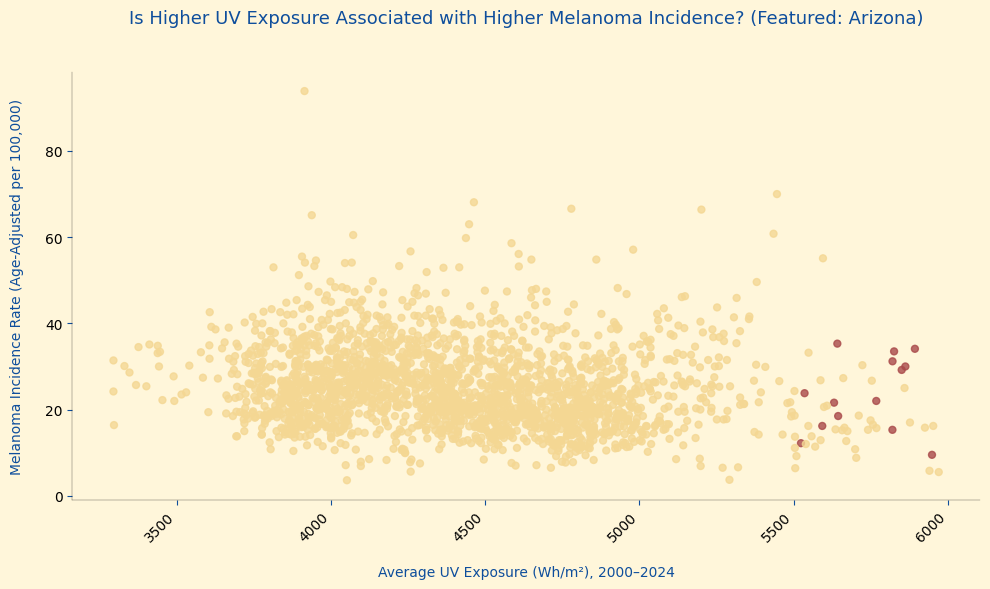

In [2179]:
plt.figure(figsize=(10, 6), facecolor = '#FFF6DA')

featured_state = avg_uv_states_25yr.sort_values(ascending=False).head(1).index[0]

colors = ["#A94A4A" if state == featured_state else "#F4D793" for state in merged_df["STATE_NAME"]]

plt.scatter(
    merged_df[[
        'UV_ Wh/m² (2000-2004)',
        'UV_ Wh/m² (2005-2009)',
        'UV_ Wh/m² (2010-2014)',
        'UV_ Wh/m² (2015-2019)',
        'UV_ Wh/m² (2020_2024)'   
    ]].mean(axis=1),              
    
    merged_df["AGE_RATE_PER100K"], 
    
    color=colors,
    alpha=0.8,
    s=25
)

plt.xlabel("Average UV Exposure (Wh/m²), 2000–2024", color = "#0E4E9C", labelpad = 15) # fixing padding around the axis labels
plt.ylabel("Melanoma Incidence Rate (Age-Adjusted per 100,000)", color = "#0E4E9C", labelpad = 15)
plt.xticks(rotation=45, ha="right")

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(color = "#0E4E9C") # Tiny markers on the axis
ax.set_facecolor("#FFF6DA")
ax.set_title(f"Is Higher UV Exposure Associated with Higher Melanoma Incidence? (Featured: {featured_state})", fontsize = 13, color = "#0E4E9C", pad = 35)

for spine in ax.spines.values():
    spine.set_linewidth(0.25)
    spine.set_alpha(0.8)


plt.tight_layout()

plt.show()